# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten
from tensorflow.keras.layers import concatenate as Concatenate
from tensorflow.keras.optimizers import Adam

from NN_functions import *

2024-06-06 21:21:06.571302: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def plot_model_history(history):
    """Plot the training and validation history for a TensorFlow network"""

    # Extract loss and accuracy
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    MAPE = history.history["MAE"]
    val_MAPE = history.history["val_MAE"]
    n_epochs = len(loss)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].plot(np.arange(n_epochs), loss, label="Training")
    ax[0].plot(np.arange(n_epochs), val_loss, label="Validation")
    ax[0].legend()
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Loss")

    ax[1].plot(np.arange(n_epochs), MAPE, label="Training")
    ax[1].plot(np.arange(n_epochs), val_MAPE, label="Validation")
    ax[1].legend()
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Mean Absolute Percent Error")


# Run NN

In [48]:
# Create the model

random_state = 3
nodes = 3

X, y = import_data()
X_train_lin, X_test_lin, X_train_sig, X_test_sig, y_train, y_test, scaler_y = split_data(X, y, random_state)
model = create_model(nodes)
#model.summary()
#plot_model(model, to_file="Plots/feed_forward_model_diagram.png",
#           show_shapes=True, show_layer_activations=True)


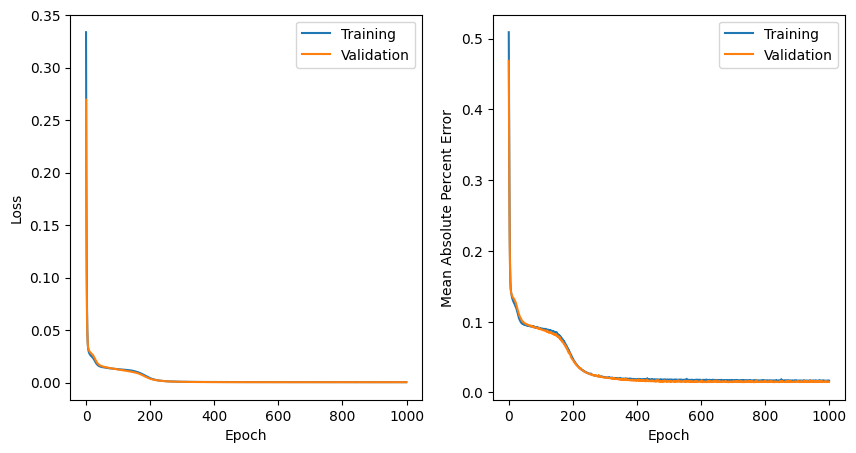

In [43]:
# Train the model

history = model.fit([X_train_lin, X_train_sig], y_train, batch_size=16,
                    epochs=1000, validation_split=0.25, shuffle=True, verbose=0)

plot_model_history(history)

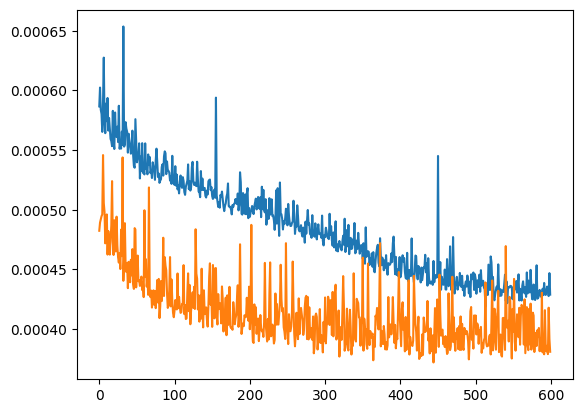

In [44]:
plt.plot(history.history["loss"][400:])
plt.plot(history.history["val_loss"][400:])

MSE = 23.921707153320312
MAE = 3.826934337615967
MAPE = 0.013825138099491596


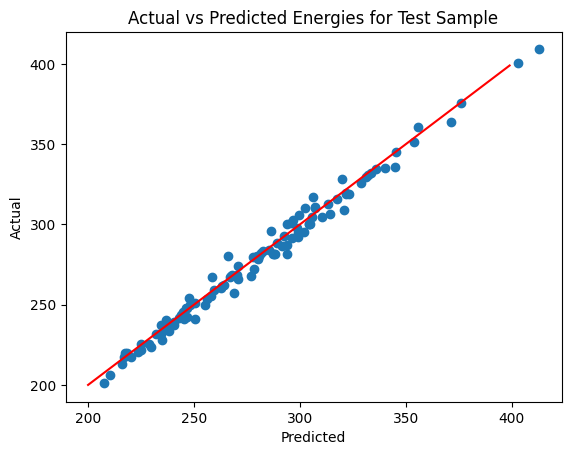

In [45]:
# Run model on testing data

y_keras = model.predict([X_test_lin, X_test_sig], batch_size=10, verbose=0)
print(f"MSE = {MSE(y_test, scaler_y.inverse_transform(y_keras))}")
print(f"MAE = {MAE(y_test, scaler_y.inverse_transform(y_keras))}")
print(f"MAPE = {MAPE(y_test, scaler_y.inverse_transform(y_keras))}")

plt.scatter(scaler_y.inverse_transform(y_keras), y_test)
plt.plot(np.arange(200,400), np.arange(200,400), color = "r")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Actual vs Predicted Energies for Test Sample")
plt.show()

# Test Model with Cross Validation

In [9]:
# Import data
X, y = import_data()

num_of_trials = 2
nodes = 3

# Initialize stat lists
random_state_list = np.zeros(num_of_trials, dtype=int)
rmse_train_list = np.zeros(num_of_trials)
mae_train_list = np.zeros(num_of_trials)
mape_train_list = np.zeros(num_of_trials)
rmse_test_list = np.zeros(num_of_trials)
mae_test_list = np.zeros(num_of_trials)
mape_test_list = np.zeros(num_of_trials)
y_train_avg_list = np.zeros(num_of_trials)
y_test_avg_list = np.zeros(num_of_trials)

# Create a dataframe to store the predictions
df_nn_preds = pd.DataFrame()

for i in tqdm.tqdm(range(num_of_trials)):
        # i is the random_state
        rand_state = i
        random_state_list[i] = rand_state

        # Create model
        X_train_lin, X_test_lin, X_train_sig, X_test_sig, y_train, y_test, scaler_y = split_data(X, y, rand_state)
        model = create_model(nodes)
   
        # Compute averages for training and testing y values
        y_train_avg = np.mean(y_train)
        y_test_avg = np.mean(y_test)
        y_train_avg_list[i] = scaler_y.inverse_transform(np.array([y_train_avg]).reshape(1, -1))[0][0]
        y_test_avg_list[i] = y_test_avg

        # Fit the model
        history = model.fit([X_train_lin, X_train_sig], y_train, batch_size=16,
                             epochs=1000, validation_split=0.25, shuffle=True, verbose=0)
        
        # Use the model to predict
        y_train_nn = model.predict([X_train_lin, X_train_sig], batch_size=10, verbose=0)
        y_train_nn = scaler_y.inverse_transform(y_train_nn).reshape(-1)
        y_test_nn = model.predict([X_test_lin, X_test_sig], batch_size=10, verbose=0)
        y_test_nn = scaler_y.inverse_transform(y_test_nn).reshape(-1)

        df_nn_preds[f"train_{rand_state}"] = y_train_nn
        df_nn_preds[f"test_{rand_state}"] = np.concatenate((y_test_nn, np.zeros(len(y_train_nn) - len(y_test_nn))))

        # Calculate the train and test statistics
        y_train = scaler_y.inverse_transform(y_train.reshape(-1, 1)).reshape(-1)
        rmse_train = np.sqrt(MSE(y_train, y_train_nn))
        mae_train = MAE(y_train, y_train_nn)
        mape_train = MAPE(y_train, y_train_nn)
        
        rmse_test = np.sqrt(MSE(y_test, y_test_nn))
        mae_test = MAE(y_test, y_test_nn)
        mape_test = MAPE(y_test, y_test_nn)

        # Put the train and test statistics in the lists
        rmse_train_list[i] = rmse_train
        mae_train_list[i] = mae_train
        mape_train_list[i] = mape_train

        rmse_test_list[i] = rmse_test
        mae_test_list[i] = mae_test
        mape_test_list[i] = mape_test

df_stats = pd.DataFrame({
        "Random State":random_state_list,
        "RMSE Train":rmse_train_list,
        "MAE Train":mae_train_list,
        "MAPE Train":mape_train_list,
        "RMSE Test":rmse_test_list,
        "MAE Test":mae_test_list,
        "MAPE Test":mape_test_list,
        "Y Train Average":y_train_avg_list,
        "Y Test Average":y_test_avg_list
})

df_nn_preds.to_csv("Results/nn_Preds_100_10pct.csv")
df_stats.to_csv("Results/nn_TrainTest_100_10pct.csv")

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [06:04<00:00, 182.23s/it]


In [10]:
df_stats

,Random State,RMSE Train,MAE Train,MAPE Train,RMSE Test,MAE Test,MAPE Test,Y Train Average,Y Test Average
0,24,5.038023,3.977682,0.014443,5.023078,3.882651,0.014432,276.097656,271.717896
1,72,5.007484,3.927461,0.014335,5.595793,4.586200,0.016610,275.338074,278.519470
